##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 迁移学习和微调

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/images/transfer_learning"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/transfer_learning.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/transfer_learning.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/images/transfer_learning.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

在本教程中，您将学习如何使用迁移学习通过预训练网络对猫和狗的图像进行分类。

预训练模型是一个之前基于大型数据集（通常是大型图像分类任务）训练的已保存网络。您可以按原样使用预训练模型，也可以使用迁移学习针对给定任务自定义此模型。

用于图像分类的迁移学习背后的理念是，如果一个模型是基于足够大且通用的数据集训练的，那么该模型将有效地充当视觉世界的通用模型。随后，您可以利用这些学习到的特征映射，而不必通过基于大型数据集训练大型模型而从头开始。

在此笔记本中，您将尝试通过以下两种方式来自定义预训练模型：

1. 特征提取：使用先前网络学习的表示从新样本中提取有意义的特征。您只需在预训练模型上添加一个将从头开始训练的新分类器，这样便可重复利用先前针对数据集学习的特征映射。

您无需（重新）训练整个模型。基础卷积网络已经包含通常用于图片分类的特征。但是，预训练模型的最终分类部分特定于原始分类任务，随后特定于训练模型所使用的类集。

1. 微调：解冻已冻结模型库的一些顶层，并共同训练新添加的分类器层和基础模型的最后几层。这样，我们便能“微调”基础模型中的高阶特征表示，以使其与特定任务更相关。

您将遵循通用的机器学习工作流。

1. 检查并理解数据
2. 构建输入流水线，在本例中使用 Keras ImageDataGenerator
3. 构成模型
    - 加载预训练的基础模型（和预训练权重）
    - 将分类层堆叠在顶部
4. 训练模型
5. 评估模型


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## 数据预处理

### 数据下载

在本教程中，您将使用包含数千个猫和狗图像的数据集。下载并解压缩包含图像的 zip 文件，然后使用 `tf.keras.preprocessing.image_dataset_from_directory` 效用函数创建一个 `tf.data.Dataset` 进行训练和验证。您可以在此[教程](https://tensorflow.google.cn/tutorials/load_data/images)中详细了解如何加载图像。

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [4]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


显示训练集中的前九个图像和标签：

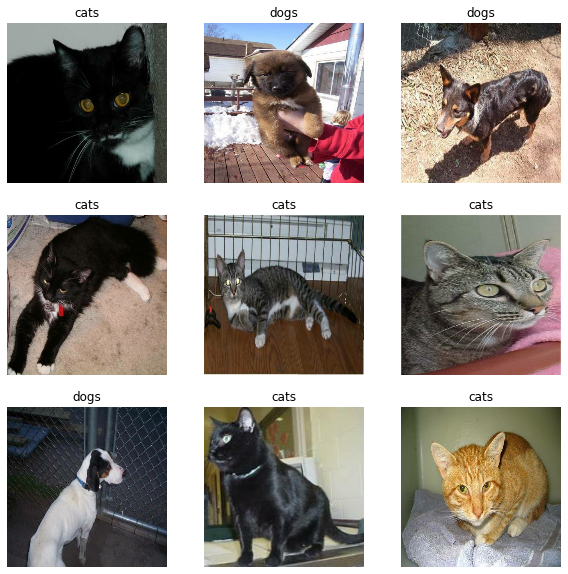

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

由于原始数据集不包含测试集，因此您需要创建一个。为此，请使用 `tf.data.experimental.cardinality` 确定验证集中有多少批次的数据，然后将其中的 20% 移至测试集。

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### 配置数据集以提高性能

使用缓冲预提取从磁盘加载图像，以免造成 I/O 阻塞。要详细了解这种方式，请参阅[数据性能](https://tensorflow.google.cn/guide/data_performance)指南。

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

AttributeError: module 'tensorflow._api.v2.data' has no attribute 'AUTOTUNE'

### 使用数据扩充

当您没有较大的图像数据集时，最好将随机但现实的转换应用于训练图像（例如旋转或水平翻转）来人为引入样本多样性。这有助于使模型暴露于训练数据的不同方面并减少[过拟合](https://tensorflow.google.cn/tutorials/keras/overfit_and_underfit)。您可以在此[教程](https://tensorflow.google.cn/tutorials/images/data_augmentation)中详细了解数据扩充。

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

注：当您调用 `model.fit` 时，这些层仅在训练过程中才会处于有效状态。在 `model.evaulate` 或 `model.fit` 中的推断模式下使用模型时，它们处于停用状态。

我们将这些层重复应用于同一个图像，然后查看结果。

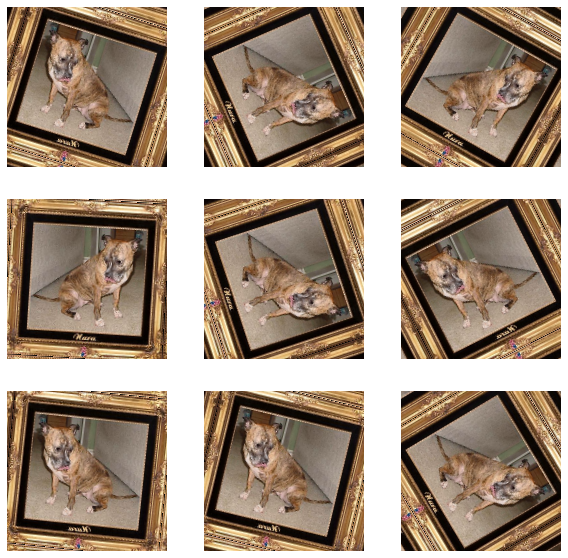

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### 重新缩放像素值

稍后，您将下载 `tf.keras.applications.MobileNetV2` 作为基础模型。此模型期望像素值处于 `[-1, 1]` 范围内，但此时，图像中的像素值处于 `[0, 255]` 范围内。要重新缩放这些像素值，请使用模型随附的预处理方法。

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

注：另外，您也可以使用 [Rescaling](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) 层将像素值从 `[0,255]` 重新缩放为 `[-1, 1]`。

In [13]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

注：如果使用其他 `tf.keras.applications`，请确保查阅 API 文档以确定它们是否期望 `[-1,1]` 或 `[0,1]` 范围内的像素，或者使用随附的 `preprocess_input` 函数。

## 从预训练卷积网络创建基础模型

您将根据 Google 开发的 **MobileNet V2** 模型来创建基础模型。此模型已基于 ImageNet 数据集进行预训练，ImageNet 数据集是一个包含 140 万个图像和 1000 个类的大型数据集。ImageNet 是一个研究训练数据集，具有各种各样的类别，例如 `jackfruit` 和 `syringe`。此知识库将帮助我们对特定数据集中的猫和狗进行分类。

首先，您需要选择将 MobileNet V2 的哪一层用于特征提取。最后的分类层（在“顶部”，因为大多数机器学习模型的图表是从下到上的）不是很有用。相反，您将按照常见做法依赖于展平操作之前的最后一层。此层被称为“瓶颈层”。与最后一层/顶层相比，瓶颈层的特征保留了更多的通用性。

首先，实例化一个已预加载基于 ImageNet 训练的权重的 MobileNet V2 模型。通过指定 **include_top=False** 参数，可以加载不包括顶部分类层的网络，这对于特征提取十分理想。

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

此特征提取程序将每个 `160x160x3` 图像转换为 `5x5x1280` 的特征块。我们看看它对一批示例图像做了些什么：

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## 特征提取

在此步骤中，您将冻结在上一步中创建的卷积基，并用作特征提取程序。此外，您还可以在其顶部添加分类器以及训练顶级分类器。

### 冻结卷积基

在编译和训练模型之前，冻结卷积基至关重要。冻结（通过设置 layer.trainable = False）可避免在训练期间更新给定层中的权重。MobileNet V2 具有许多层，因此将整个模型的 `trainable` 标记设置为 False 会冻结所有这些层。

In [16]:
base_model.trainable = False

### 有关 BatchNormalization 层的重要说明

许多模型都包含 `tf.keras.layers.BatchNormalization` 层。此层是一个特例，应在微调的上下文中采取预防措施，如本教程后面所示。

设置 `layer.trainable = False` 时，`BatchNormalization` 层将以推断模式运行，并且不会更新其均值和方差统计信息。

解冻包含 BatchNormalization 层的模型以进行微调时，应在调用基础模型时通过传递 `training = False` 来使 BatchNormalization 层保持在推断模式下。否则，应用于不可训练权重的更新将破坏模型已经学习到的内容。

有关详细信息，请参阅[迁移学习指南](https://tensorflow.google.cn/guide/keras/transfer_learning)。

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### 添加分类头

要从特征块生成预测，请使用 `tf.keras.layers.GlobalAveragePooling2D` 层在 `5x5` 空间位置内取平均值，以将特征转换成每个图像一个向量（包含 1280 个元素）。

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


应用 `tf.keras.layers.Dense` 层将这些特征转换成每个图像一个预测。您在此处不需要激活函数，因为此预测将被视为 `logit` 或原始预测值。正数预测 1 类，负数预测 0 类。

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


通过使用 [Keras 函数式 API](https://tensorflow.google.cn/guide/keras/functional) 将数据扩充、重新缩放、base_model 和特征提取程序层链接在一起来构建模型。如前面所述，由于我们的模型包含 BatchNormalization 层，因此请使用 training = False。

In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

NotImplementedError: Cannot convert a symbolic Tensor (sequential/random_rotation/rotation_matrix_1/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

### 编译模型

在训练模型前，需要先编译模型。由于存在两个类，并且模型提供线性输出，请将二进制交叉熵损失与 `from_logits=True` 结合使用。

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

NameError: name 'model' is not defined

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

MobileNet 中的 250 万个参数被冻结，但在密集层中有 1200 个*可训练*参数。它们分为两个 `tf.Variable` 对象，即权重和偏差。

In [23]:
len(model.trainable_variables)

2

### 训练模型

经过 10 个周期的训练后，您应该在验证集上看到约 94% 的准确率。


In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 2s 17ms/step - loss: 0.6144 - accuracy: 0.5718


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.61
initial accuracy: 0.57


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 4s 24ms/step - loss: 0.5914 - accuracy: 0.6590 - val_loss: 0.4107 - val_accuracy: 0.7351
Epoch 2/10
63/63 [==============================] - 1s 22ms/step - loss: 0.4526 - accuracy: 0.7555 - val_loss: 0.3159 - val_accuracy: 0.8230
Epoch 3/10
63/63 [==============================] - 1s 22ms/step - loss: 0.3671 - accuracy: 0.8195 - val_loss: 0.2532 - val_accuracy: 0.8800
Epoch 4/10
63/63 [==============================] - 1s 22ms/step - loss: 0.3171 - accuracy: 0.8615 - val_loss: 0.2163 - val_accuracy: 0.8960
Epoch 5/10
63/63 [==============================] - 1s 22ms/step - loss: 0.3079 - accuracy: 0.8635 - val_loss: 0.1893 - val_accuracy: 0.9220
Epoch 6/10
63/63 [==============================] - 1s 22ms/step - loss: 0.2701 - accuracy: 0.8875 - val_loss: 0.1751 - val_accuracy: 0.9344
Epoch 7/10
63/63 [==============================] - 1s 22ms/step - loss: 0.2566 - accuracy: 0.8860 - val_loss: 0.1596 - val_accuracy: 0.9356
Epoch 8/10
63

### 学习曲线

我们看一下使用 MobileNet V2 基础模型作为固定特征提取程序时训练和验证准确率/损失的学习曲线。

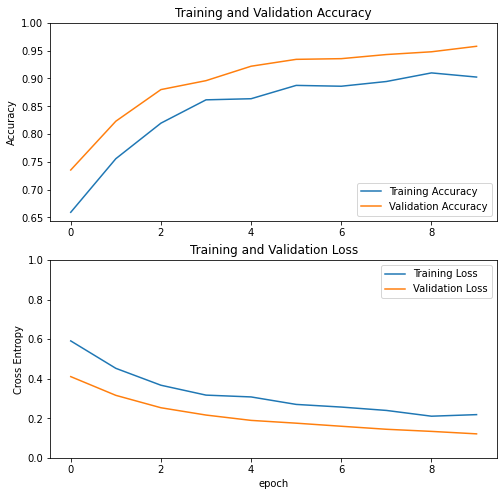

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

注：如果您想知道为什么验证指标明显优于训练指标，主要原因是 `tf.keras.layers.BatchNormalization` 和 `tf.keras.layers.Dropout` 等层会影响训练期间的准确率。在计算验证损失时，它们处于关闭状态。

在较小程度上，这也是因为训练指标报告的是某个周期的平均值，而验证指标则在经过该周期后才进行评估，因此验证指标会看到训练时间略长一些的模型。

## 微调

在特征提取实验中，您仅在 MobileNet V2 基础模型的顶部训练了一些层。预训练网络的权重在训练过程中**未**更新。

进一步提高性能的一种方式是在训练（或“微调”）预训练模型顶层的权重的同时，另外训练您添加的分类器。训练过程将强制权重从通用特征映射调整为专门与数据集相关联的特征。

注：只有在您使用设置为不可训练的预训练模型训练顶级分类器之后，才能尝试这样做。如果您在预训练模型的顶部添加一个随机初始化的分类器并尝试共同训练所有层，则梯度更新的幅度将过大（由于分类器的随机权重所致），这将导致您的预训练模型忘记它已经学习的内容。

另外，您还应尝试微调少量顶层而不是整个 MobileNet 模型。在大多数卷积网络中，层越高，它的专门程度就越高。前几层学习非常简单且通用的特征，这些特征可以泛化到几乎所有类型的图像。随着您向上层移动，这些特征越来越特定于训练模型所使用的数据集。微调的目标是使这些专用特征适应新的数据集，而不是覆盖通用学习。

### 解冻模型的顶层


您需要做的是解冻 `base_model` 并将底层设置为不可训练。随后，您应该重新编译模型（使这些更改生效的必需操作），然后恢复训练。

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### 编译模型

当您正在训练一个大得多的模型并且想要重新调整预训练权重时，请务必在此阶段使用较低的学习率。否则，您的模型可能会很快过拟合。

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [32]:
len(model.trainable_variables)

56

### 继续训练模型

如果您已提前训练至收敛，则此步骤将使您的准确率提高几个百分点。

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 7s 42ms/step - loss: 0.1613 - accuracy: 0.9275 - val_loss: 0.0577 - val_accuracy: 0.9790
Epoch 11/20
63/63 [==============================] - 2s 29ms/step - loss: 0.1182 - accuracy: 0.9545 - val_loss: 0.0581 - val_accuracy: 0.9814
Epoch 12/20
63/63 [==============================] - 2s 29ms/step - loss: 0.1140 - accuracy: 0.9520 - val_loss: 0.0709 - val_accuracy: 0.9790
Epoch 13/20
63/63 [==============================] - 2s 29ms/step - loss: 0.1015 - accuracy: 0.9615 - val_loss: 0.0537 - val_accuracy: 0.9777
Epoch 14/20
63/63 [==============================] - 2s 30ms/step - loss: 0.0989 - accuracy: 0.9610 - val_loss: 0.0413 - val_accuracy: 0.9839
Epoch 15/20
63/63 [==============================] - 2s 30ms/step - loss: 0.0754 - accuracy: 0.9675 - val_loss: 0.0573 - val_accuracy: 0.9752
Epoch 16/20
63/63 [==============================] - 2s 29ms/step - loss: 0.0709 - accuracy: 0.9720 - val_loss: 0.0441 - val_accuracy: 0.9864
Epoch 

在微调 MobileNet V2 基础模型的最后几层并在这些层上训练分类器时，我们来看一下训练和验证准确率/损失的学习曲线。验证损失比训练损失高得多，因此可能存在一些过拟合。

当新的训练集相对较小且与原始 MobileNet V2 数据集相似时，也可能存在一些过拟合。


经过微调后，模型在验证集上的准确率几乎达到 98%。

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

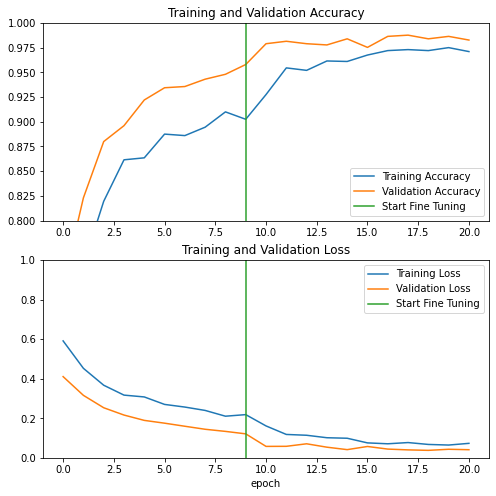

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 评估和预测

最后，您可以使用测试集在新数据上验证模型的性能。

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 14ms/step - loss: 0.0286 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


现在，您可以使用此模型来预测您的宠物是猫还是狗。

Predictions:
 [1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1]
Labels:
 [1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1]


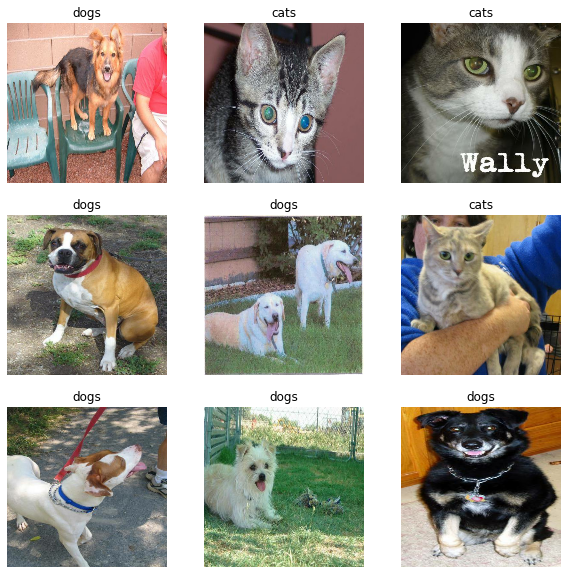

In [37]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## 总结

- **使用预训练模型进行特征提取**：使用小型数据集时，常见做法是利用基于相同域中的较大数据集训练的模型所学习的特征。为此，您需要实例化预训练模型并在顶部添加一个全连接分类器。预训练模型处于“冻结状态”，训练过程中仅更新分类器的权重。在这种情况下，卷积基提取了与每个图像关联的所有特征，而您刚刚训练了一个根据给定的提取特征集确定图像类的分类器。

- **微调预训练模型**：为了进一步提高性能，可能需要通过微调将预训练模型的顶层重新用于新的数据集。在本例中，您调整了权重，以使模型学习特定于数据集的高级特征。当训练数据集较大且与训练预训练模型所使用的原始数据集非常相似时，通常建议使用这种技术。

要了解详情，请参阅[迁移学习指南](https://tensorflow.google.cn/guide/keras/transfer_learning)。
